In [87]:
import os

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer("english")
from nltk import FreqDist
import spacy

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from nltk.tokenize import sent_tokenize
import re
import textstat
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

[nltk_data] Downloading package punkt to /Users/kevinxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kevinxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kevinxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kevinxu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
path = 'rawdata/PC.tsv.gz'
raw_df = pd.read_csv(path,sep='\t', on_bad_lines='skip')

# 1 Preprocessing

In [3]:
# 1.1 only get total_votes >= 50
df = raw_df[raw_df['total_votes'] >= 40]

In [4]:
df.shape

(38814, 15)

In [5]:
df.columns.tolist()

['marketplace',
 'customer_id',
 'review_id',
 'product_id',
 'product_parent',
 'product_title',
 'product_category',
 'star_rating',
 'helpful_votes',
 'total_votes',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [6]:
df.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

In [7]:
# 1.2 Removing Nulls & duplicate
df.isnull().sum()
df = df.dropna()


In [8]:
# 1.3 Preparing columns
# review
df['review'] = df['review_headline'] + " " + df['review_body']
df=df.drop(['review_headline', 'review_body'], axis=1)
df = df.drop_duplicates(subset=['review'])

In [9]:
# review_date type
# df['review_date'] =  pd.to_datetime(df['unixReviewTime'],unit='s')

In [10]:
# vote ratio  => label
df['vote_ratio'] = df['helpful_votes'] / df['total_votes']
df=df.drop(['helpful_votes', 'total_votes'], axis=1)

In [11]:
threshold = 0.8
df['helpfulness'] = [1 if x >= threshold else 0 for x in df['vote_ratio']]

In [12]:
# verified purchase to 1 0
df['verified_purchase'] = [1 if x == 'Y' else 0 for x in df['verified_purchase']]

In [13]:
# verified purchase to 1 0
df['vine'] = [1 if x == 'Y' else 0 for x in df['vine']]

In [14]:
# sentence tokenize
df['sentence_count'] = df.apply(lambda row: sent_tokenize(row['review']), axis=1).apply(lambda x: len(x))

# 2 EDA

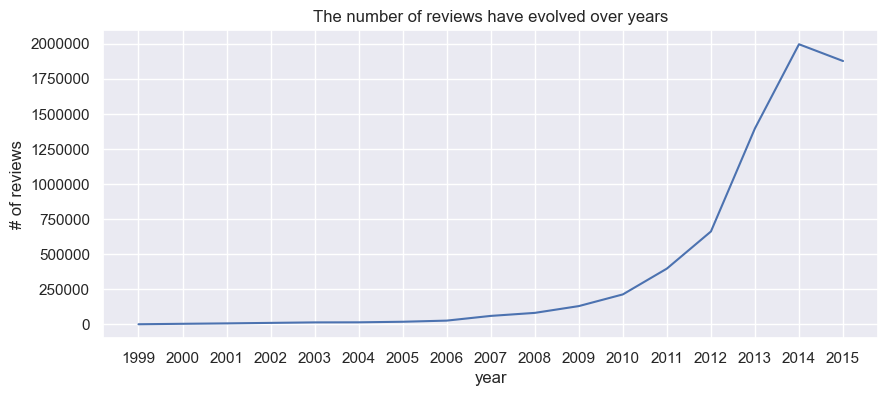

In [15]:
# 2.0 trending of reviews #
raw_df['year'] = pd.to_datetime(raw_df['review_date']).dt.year

sns.set(rc={'figure.figsize':(10,4)})
year_reviews = raw_df['year'].groupby(raw_df['year']).count().reset_index(name="# of reviews").sort_values(by=['# of reviews'], ascending=False)

ax = sns.lineplot(x="year", y="# of reviews", data=year_reviews)

ax.yaxis.get_major_formatter().set_scientific(False)
ax.set(xticks=year_reviews['year'].values)
plt.title('The number of reviews have evolved over years')
plt.show()

In [16]:
# 2.1.1 customers write most reviews
customer_reviews = raw_df['customer_id'].groupby(raw_df['customer_id']).count().reset_index(name="# of reviews").sort_values(by=['# of reviews'], ascending=False)
top10_customer = customer_reviews[:10]
top10_customer

,customer_id,# of reviews
1463359,17957446,458
3305704,44834233,442
4029462,52938899,366
3380402,45664110,275
3684497,49452274,261
3803234,50820654,256
825943,12200139,251
3327196,45070473,251
2433469,32038204,241
3669058,49266466,240


In [17]:
# 2.1.2 how the rating of  these top 10 customer distribute

top10_customerID = top10_customer['customer_id'].to_numpy()

top10_customer_ratings = raw_df[raw_df['customer_id'].isin(top10_customerID)][['customer_id', 'star_rating']]

top10_customer_ratings = top10_customer_ratings.groupby(["customer_id"], as_index=False).agg({'star_rating': [np.size, np.min, np.max, np.median, np.mean]})
top10_customer_ratings.columns = top10_customer_ratings.columns.droplevel(0)
top10_customer_ratings = top10_customer_ratings.sort_values(['size'],ascending=False).head(10)
top10_customer_ratings = top10_customer_ratings.rename(columns={ top10_customer_ratings.columns[0]: "customer_id" })
top10_customer_ratings = top10_customer_ratings.rename(columns={"size": "total_reviews"})
top10_customer_ratings

,customer_id,total_reviews,amin,amax,median,mean
1,17957446,458,1,5,5.0,4.676856
3,44834233,442,1,5,5.0,4.742081
9,52938899,366,1,5,5.0,4.341530
5,45664110,275,2,5,4.0,3.938182
7,49452274,261,1,5,5.0,4.482759
8,50820654,256,2,5,5.0,4.523438
0,12200139,251,1,5,5.0,4.808765
4,45070473,251,1,5,5.0,4.836653
2,32038204,241,1,5,5.0,4.585062
6,49266466,240,2,5,5.0,4.454167


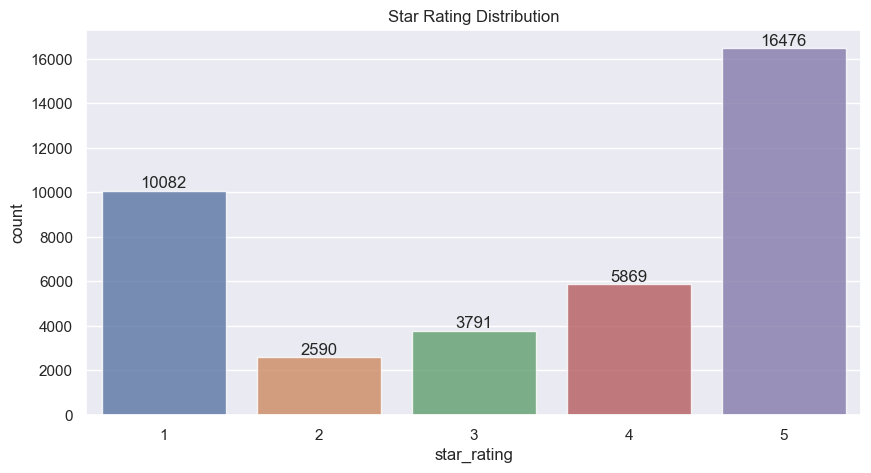

In [18]:
# 2.3.1 how total rating distribute
sns.set(rc={'figure.figsize':(10,5)})
ratings = df['star_rating'].groupby(df['star_rating']).count().reset_index(name="count")
ax = sns.barplot(data=ratings, x='star_rating', y='count', order=ratings['star_rating'], alpha=0.8)
ax.set(title='Star Rating Distribution')
ax.bar_label(ax.containers[0])

plt.show()

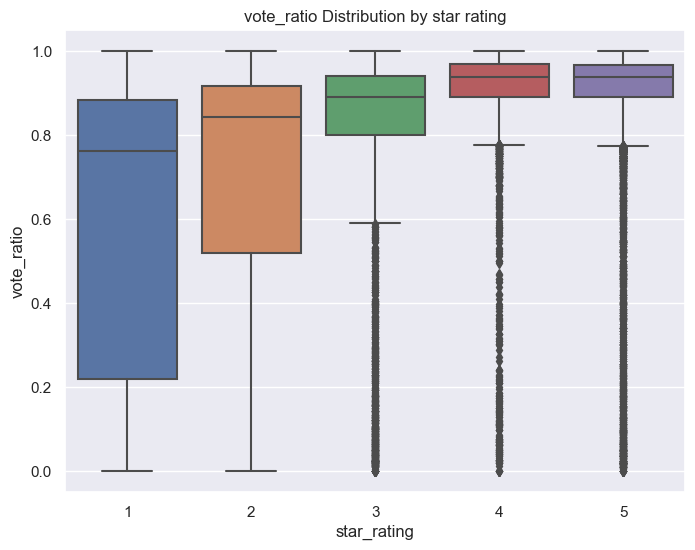

In [19]:
# 2.3.2 rating and vote_ratio     vote helpful
sns.set(rc={'figure.figsize':(8,6)})
rating_helpfulness = df[['star_rating', 'vote_ratio']]
ax = sns.boxplot(x="star_rating", y="vote_ratio", data=rating_helpfulness)
ax.set(title='vote_ratio Distribution by star rating')
plt.show()

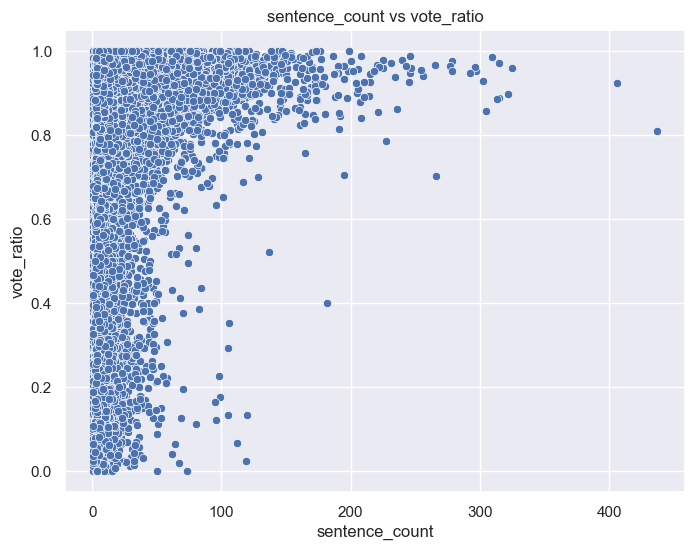

In [20]:
# 2.3.3 vote_ratio vs sentence_count
# pd.options.mode.chained_assignment = None

sentence_ratio = df[['sentence_count', 'vote_ratio']]

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(data=sentence_ratio, x='sentence_count', y='vote_ratio')
ax.set(title='sentence_count vs vote_ratio')

plt.show()

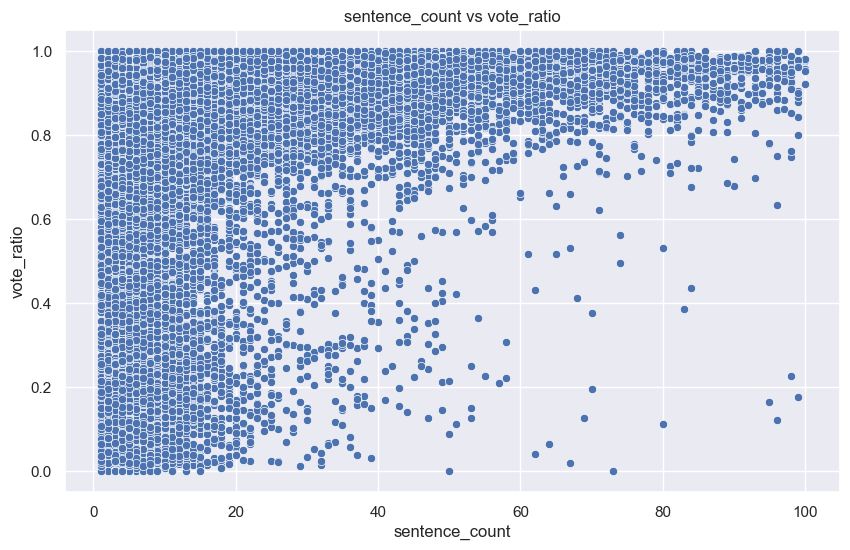

In [21]:
# 2.3.3.1 vote_ratio vs sentence_count < 1 to 100
sentence100_ratio = sentence_ratio[sentence_ratio['sentence_count'] <= 100]

sns.set(rc={'figure.figsize':(10,6)})
ax = sns.scatterplot(data=sentence100_ratio, x='sentence_count', y='vote_ratio')
ax.set(title='sentence_count vs vote_ratio')

plt.show()


In [ ]:
# # Calculate Pearson coefficient of correlation
# data_for_corr = data.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Time',
#                            'HelpfulnessDenominator', 'Summary', 'Text'], 
#                           axis=1)

# data_for_corr.corr()
# # Visualize correlation coefficients as a heatmap
# sns.heatmap(data_for_corr.corr());

# 3 Text Preprocessing

Tokenizing

Removing stopwords

In [40]:
# word count
punct_remover = str.maketrans('','', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
## remove num with word, punctuaction, stopword
def extract_words(sentence):
    sentence_nodigits = re.sub("\d+", "", sentence)
    words = re.sub("[^\w]", " ",  sentence_nodigits).split()
    words_punct = [w.translate(punct_remover) for w in words]
    words_stop = [w for w in words_punct if w not in stopwords.words('english')]
    words_len = [word for word in words_stop if len(word) > 2]
    return words_len

df['words'] = [extract_words(x) for x in df['review']]
df['word_count'] = [len(x) for x in df['words']]

In [24]:
# Automated Readability Index (ARI)
df['ARI'] = [textstat.automated_readability_index(x) for x in df['review']]

In [ ]:
## bag of words

In [52]:
vocabulary = list(itertools.chain.from_iterable(out_data['words'].tolist()))
vocab = Counter()
vocab.update(vocabulary)
commom_word_threshold = 5000
tokens = [k for k,c in vocab.most_common(commom_word_threshold)]

In [70]:
vectorizer = CountVectorizer(max_features=5000, vocabulary=tokens)

In [55]:
out_data['words_text'] = out_data.apply(lambda row: re.sub(r'\[',"",(str(row['words']))), axis=1)
out_data['words_text'] = out_data.apply(lambda row: re.sub(r'\'',"",(str(row['words_text']))), axis=1)
out_data['words_text'] = out_data.apply(lambda row: re.sub(r',',"",(str(row['words_text']))), axis=1)
out_data['words_text'] = out_data.apply(lambda row: re.sub(r'\]',"",(str(row['words_text']))), axis=1)

414    Cannot used headphones plan use iPad mini head...
Name: words_text, dtype: object

In [58]:
pd.set_option('display.max_colwidth', None)
out_data['words_text'].head(n=1)

414    Cannot used headphones plan use iPad mini headphones purchase several reviewers state headphone jack cannot accessed due thick protective edge around area There cut headphones standard jack would fit slot returning item
Name: words_text, dtype: object

In [71]:
train_features = vectorizer.fit_transform(out_data['words_text'])

/Users/kevinxu/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1322: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [76]:
train_features.shape

In [221]:
a = out_data
a = a[a['words_text'].str.len() > 0]
a['words_text'].isnull().values.any()

False

In [222]:
# data after cleaning we need
output_data = out_data[out_data['words_text'].str.len() > 0]
output_data.to_csv('data/out.csv') 

# 4 MODEL

In [203]:
# split data
total_len = len(out_data)
val_len = round(0.1 * total_len)


y = out_data['helpfulness']
X = out_data[['star_rating', 'vine', 'verified_purchase', 'words_text', 'sentence_count', 'word_count', 'ARI']]
# X = out_data[['star_rating', 'vine', 'verified_purchase', 'review', 'sentence_count', 'word_count', 'ARI',
#        'words', 'words_text']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_len,
                                                    random_state=123)

In [204]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [205]:
# 'star_rating', 'vine', 'verified_purchase', 'sentence_count', 'word_count', 'ARI'
numeric_features = ['star_rating', 'vine', 'verified_purchase', 'sentence_count', 'word_count', 'ARI']

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

In [206]:
import string
from sklearn.preprocessing import FunctionTransformer


stop_list = stopwords.words('english')
stop_list += list(string.punctuation)
stop_list += ['br', '.<', '..', '...', '``', "''", '--']

# 'review'
categorical_transformer = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000))
])

categorical_features = 'words_text'

In [207]:
from sklearn.compose import ColumnTransformer

In [208]:
feature_transformers = [
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
]



feature_preprocessor = ColumnTransformer(transformers=feature_transformers,remainder='drop')

In [209]:
from sklearn.ensemble import RandomForestClassifier

In [210]:
pipe_bigram_rf = Pipeline([('feature_preprocessor',feature_preprocessor),
                        ('forest', RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1))])

pipe_bigram_rf.fit(X_train, y_train)

Pipeline(steps=[('feature_preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['star_rating', 'vine',
                                                   'verified_purchase',
                                                   'sentence_count',
                                                   'word_count', 'ARI']),
                                                 ('categorical',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer(max_features=5000))]),
                                                  'words_text')])),
                ('forest', RandomForestClassifier(n_jobs=-1))])

In [211]:
# Predict and score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [212]:
# Validate
y_pred_test = pipe_bigram_rf.predict(X_test)
print('Validation accuracy:', accuracy_score(y_test, y_pred_test))

Validation accuracy: 0.8188611182684875


In [213]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.36      0.49       953
           1       0.82      0.97      0.89      2928

    accuracy                           0.82      3881
   macro avg       0.81      0.66      0.69      3881
weighted avg       0.81      0.82      0.79      3881



In [198]:
# reference
# Sthanu Ramakrishnan https://webpages.charlotte.edu/sramak11/6156/6156_Group_Project.html#topic=0&lambda=1&term=
# https://cs229.stanford.edu/proj2014/Jordan%20Rodak,%20Minna%20Xiao,%20Steven%20Longoria,%20Predicting%20Helpfulness%20Ratings%20of%20Amazon%20Product%20Reviews.pdf
# https://stackoverflow.com/questions/29244286/how-to-flatten-a-2d-list-to-1d-without-using-numpy
# https://towardsdatascience.com/predicting-the-helpfulness-of-peer-written-product-reviews-ef7a0dfea2c3